<a href="https://colab.research.google.com/github/RogMaverick18/ML-Lab-assignments/blob/main/ML_Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


Train (One Feature) - MSE: 7.7985, RMSE: 2.7926, MAPE: 0.8197, R²: 0.0547
Test (One Feature) - MSE: 9.3942, RMSE: 3.0650, MAPE: 2309190777307136.0000, R²: -0.1387
Train (All Features) - MSE: 0.0000, RMSE: 0.0004, MAPE: 0.0000, R²: 1.0000
Test (All Features) - MSE: 4.9615, RMSE: 2.2275, MAPE: 1278979520593920.0000, R²: 0.3986
Silhouette Score: 0.0712
Calinski-Harabasz Score: 20.6310
Davies-Bouldin Index: 3.6620


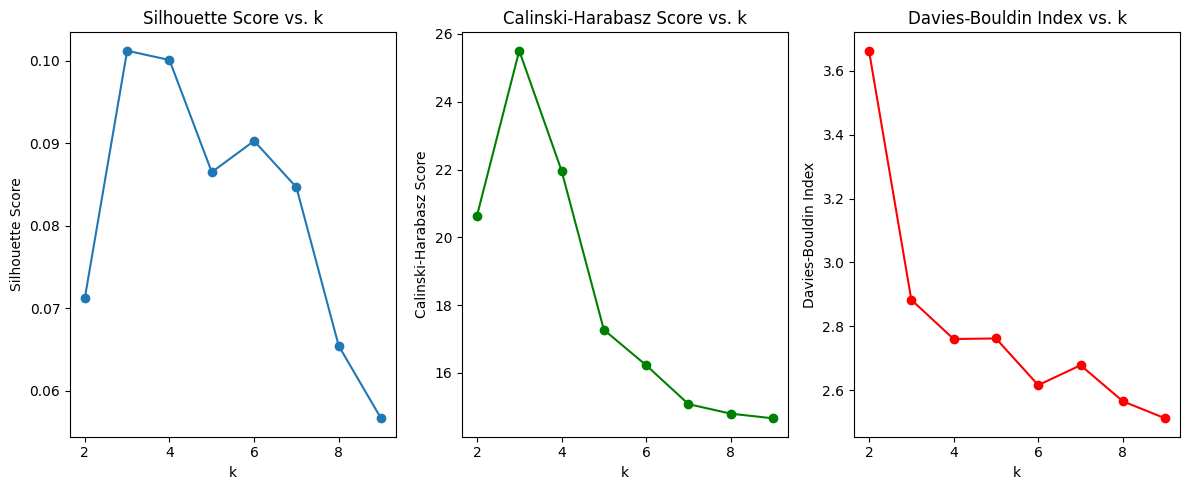

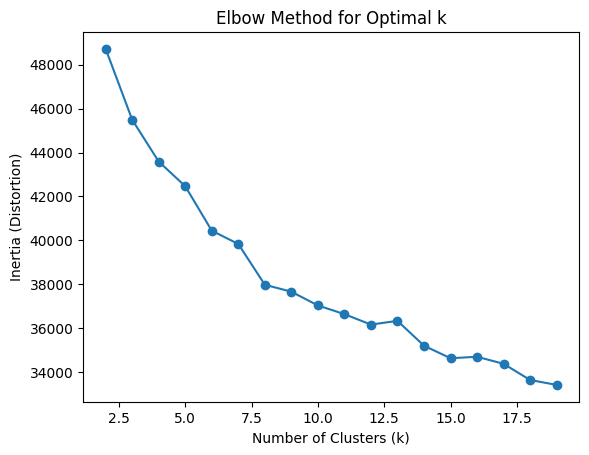

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

#  Load Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to dataset
DATA_DIR = "/content/drive/MyDrive/Flower/flower_subset"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Pretrained ResNet-50 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final FC layer
model.eval()
model.to(device)

# Custom Dataset Class (Fix for Directory Issues)
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Get class labels
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):  # Skip if not a directory
                continue

            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                if os.path.isfile(img_path):  # Ensure it's a file, not a directory
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Extract Features using ResNet-50
def extract_features(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []

    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            output = model(images)
            output = output.view(output.size(0), -1)  # Flatten
            features.append(output.cpu().numpy())
            labels.append(lbls.numpy())

    return np.vstack(features), np.hstack(labels)

# Load Dataset & Extract Features
train_dataset = ImageDataset(TRAIN_DIR, transform)
val_dataset = ImageDataset(VAL_DIR, transform)

X_train, y_train = extract_features(train_dataset)
X_test, y_test = extract_features(val_dataset)

# A1 & A2: Linear Regression (Using One Feature)
feature_idx = 0  # Choosing the first extracted feature

X_train_reg = X_train[:, feature_idx].reshape(-1, 1)
X_test_reg = X_test[:, feature_idx].reshape(-1, 1)

reg = LinearRegression().fit(X_train_reg, y_train)
y_train_pred = reg.predict(X_train_reg)
y_test_pred = reg.predict(X_test_reg)

# Compute Regression Metrics (One Feature)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train (One Feature) - MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAPE: {mape_train:.4f}, R²: {r2_train:.4f}")
print(f"Test (One Feature) - MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAPE: {mape_test:.4f}, R²: {r2_test:.4f}")

# A3: Linear Regression (Using All Features)
reg_all = LinearRegression().fit(X_train, y_train)
y_train_pred_all = reg_all.predict(X_train)
y_test_pred_all = reg_all.predict(X_test)

# Compute Regression Metrics (All Features)
mse_train_all = mean_squared_error(y_train, y_train_pred_all)
rmse_train_all = np.sqrt(mse_train_all)
mape_train_all = mean_absolute_percentage_error(y_train, y_train_pred_all)
r2_train_all = r2_score(y_train, y_train_pred_all)

mse_test_all = mean_squared_error(y_test, y_test_pred_all)
rmse_test_all = np.sqrt(mse_test_all)
mape_test_all = mean_absolute_percentage_error(y_test, y_test_pred_all)
r2_test_all = r2_score(y_test, y_test_pred_all)

print(f"Train (All Features) - MSE: {mse_train_all:.4f}, RMSE: {rmse_train_all:.4f}, MAPE: {mape_train_all:.4f}, R²: {r2_train_all:.4f}")
print(f"Test (All Features) - MSE: {mse_test_all:.4f}, RMSE: {rmse_test_all:.4f}, MAPE: {mape_test_all:.4f}, R²: {r2_test_all:.4f}")

# A4: k-Means Clustering (k=2)
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_train)

# A5: Compute Clustering Metrics
sil_score = silhouette_score(X_train, kmeans.labels_)
ch_score = calinski_harabasz_score(X_train, kmeans.labels_)
db_index = davies_bouldin_score(X_train, kmeans.labels_)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Calinski-Harabasz Score: {ch_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")


# A6: k-Means for Different k Values
k_values = range(2, 10)
sil_scores, ch_scores, db_scores = [], [], []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X_train)
    sil_scores.append(silhouette_score(X_train, kmeans.labels_))
    ch_scores.append(calinski_harabasz_score(X_train, kmeans.labels_))
    db_scores.append(davies_bouldin_score(X_train, kmeans.labels_))

# Plot k vs. Clustering Metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. k")

plt.subplot(1, 3, 2)
plt.plot(k_values, ch_scores, marker='o', color='green')
plt.xlabel("k")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Score vs. k")

plt.subplot(1, 3, 3)
plt.plot(k_values, db_scores, marker='o', color='red')
plt.xlabel("k")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs. k")

plt.tight_layout()
plt.show()

# A7: Elbow Method for Optimal k
distortions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k).fit(X_train)
    distortions.append(kmeans.inertia_)

plt.plot(range(2, 20), distortions, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Distortion)")
plt.title("Elbow Method for Optimal k")
plt.show()
